In [1]:
# reference mark's deep learning implementation for structured dataset.
# [Part1](https://medium.com/@markryan_69718/deep-learning-on-structured-data-part-1-7f08584b9883)
# [part2](https://medium.com/@markryan_69718/deep-learning-on-structured-data-part-2-5d888b966e9)

In [2]:
# other references with fastai
# https://www.fast.ai/2018/04/29/categorical-embeddings/
# https://towardsdatascience.com/structured-deep-learning-b8ca4138b848
# https://towardsdatascience.com/deep-learning-structured-data-8d6a278f3088
# https://forums.fast.ai/t/success-with-deep-learning-on-structured-data/19074/4

In [93]:
import zipfile, os, time, datetime, math, missingno, re, pickle, warnings
import numpy as np
import pandas as pd
from fuzzywuzzy import process
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
def sc_remover(text):
    return re.sub('[^A-Za-z0-9/.()]+', '', text)

In [3]:
# data input
# import 2 xlsx files and merge
filedir = "./Datasets/KMM/20181212/"
filenm = ["Vehicles part 1", "Vehicles part 2"]

for jj in filenm:
    kmm_cust = zipfile.ZipFile(os.path.join(filedir, jj)+".zip")
    kmm_cust.extract(jj+".xlsx", filedir)
    kmm_cust.close()
    
cust1 = pd.read_excel(os.path.join(filedir, filenm[0])+".xlsx")
cust1.rename(columns=dict(cust1.iloc[0,:]), inplace=True)
cust1 = cust1.iloc[1:,:]

cust2 = pd.read_excel(os.path.join(filedir, filenm[1])+".xlsx")
cust2.rename(columns=dict(cust2.iloc[0,:]), inplace=True)
cust2 = cust2.iloc[1:,:]
# sum(cust1.columns != cust2.columns) # if 0 is shown, OK

vehicle = pd.concat([cust1, cust2], axis =0)
vehicle = vehicle.reset_index(drop=True)
# missingno.matrix(vehicle)

In [4]:
# data format convert and cleanup data
# fill in missing values
vehicle['MFGD_DT'] = pd.to_datetime(vehicle['MFGD_DT'])
vehicle['ODOMTR_SALE'] = vehicle['ODOMTR_SALE'].astype(float)
vehicle['MFGD_YR'] = vehicle['MFGD_DT'].dt.year.astype(str)
vehicle['MFGD_MN'] = vehicle['MFGD_DT'].dt.month.astype(str)
vehicle['MFGD_DY'] = vehicle['MFGD_DT'].dt.day.astype(str)
vehicle['MFGD_WD'] = vehicle['MFGD_DT'].dt.weekday.astype(str)
vehicle['ODOMTR_SALE'] = vehicle['ODOMTR_SALE'].fillna(0)

vehicle['X_COMPANY_CAR_FLG'] = vehicle.X_COMPANY_CAR_FLG.apply(lambda x: x=='Y')
vehicle['FLEET_FLG'] = vehicle.FLEET_FLG.apply(lambda x: x=='Y')

vehicle['X_TRANSMISSION_DESC'] = vehicle.X_TRANSMISSION_DESC.str.split()
vehicle['X_MODEL_DESCRIPTION'] = vehicle.X_MODEL_DESCRIPTION.str.split()

engine_desc = vehicle.X_ENGINE_DESC.str.split('/')
vehicle['X_ENGINE_DESC1'] = list(zip(*engine_desc))[0]
vehicle['X_ENGINE_DESC2'] = list(zip(*engine_desc))[1]

vehicle = vehicle.drop(['X_ENGINE_DESC',"DEALER_RCPT_DT", "FIRST_SALE_DT", 
                        "MFGD_DT", "X_REGO_DT",'ROW_ID', 'X_ENGINE_NUM','ASSET_NUM', 
                        'X_COMPANY_CAR_FLG', 'FLEET_FLG'], axis = 1)

In [5]:
vehicle.head(2)

INT_COLOR_CD   EXT_COLOR_CD  ODOMTR_SALE MODEL_YR X_SERIES_DESC  \
0  STONE BEIGE  REMINGTON RED          0.0     2016       SORENTO   
1  STONE BEIGE  REMINGTON RED          0.0     2016       SORENTO   

  X_BUILD_PLANT_CD X_MODEL_DESC          X_TRANSMISSION_DESC  \
0             KMMG           W7  [6, SPEED, 2WD, /AUTO, T/M]   
1             KMMG           W7  [6, SPEED, 2WD, /AUTO, T/M]   

                     X_MODEL_DESCRIPTION MFGD_YR MFGD_MN MFGD_DY MFGD_WD  \
0  [Sorento, 3.3L, EX, PACK, A/T, -, 7P]    2015       7      28       1   
1  [Sorento, 3.3L, EX, PACK, A/T, -, 7P]    2015       7      28       1   

  X_ENGINE_DESC1 X_ENGINE_DESC2  
0            GDI           DOHC  
1            GDI           DOHC

In [6]:
# Define target
# if zero vs one ratio gap is significantly high. need to consider skew data processing and data imbalance.
vehicle['y'] = vehicle.ODOMTR_SALE.apply(lambda x: x>0)

print("zero target values",(vehicle['y']==False).sum())
print("one target values",(vehicle['y']==True).sum())

vehicle = vehicle.drop(['ODOMTR_SALE'], axis=1)

zero target values 105416
one target values 153914


In [7]:
train_test_ratio = 0.2
train_eval_ratio = 0.6

dropout = 0.6
l2_lambda = 7.5
batch_size = 128
epochs = 10
lr = 0.001

In [85]:
# Define feature columns
sequential_columns = ['X_TRANSMISSION_DESC','X_MODEL_DESCRIPTION']
categorical_columns = ["INT_COLOR_CD","EXT_COLOR_CD","MODEL_YR",
                       "X_SERIES_DESC","X_BUILD_PLANT_CD","X_MODEL_DESC",
                       "MFGD_YR","MFGD_MN","MFGD_DY","MFGD_WD","X_ENGINE_DESC1",
                       "X_ENGINE_DESC2"]

# Define test / training sets
train, test = train_test_split(vehicle, test_size = train_test_ratio)

In [86]:
column_tokens = {}
max_sequence_for_embeds = {}

# encode categorical columns
for column in categorical_columns:
    le = LabelEncoder()
    le.fit(pd.concat([train[column], test[column]]))
    train[column] = le.transform(train[column])##
    test[column] = le.transform(test[column])##
    column_tokens.update({column:le})

# process sequential columns
for column in sequential_columns:
    seq_token = Tokenizer()
    seq_token.fit_on_texts(pd.concat([train[column], test[column]]))
    max_sequence_for_embeds[column] = len(seq_token.word_index) + 1
    train[column] = seq_token.texts_to_sequences(train[column])##
    test[column] = seq_token.texts_to_sequences(test[column])##
    column_tokens.update({column:seq_token})

# print(max_sequence_for_embeds)

with open("./Datasets/column_tokens.pkl",'wb') as f:
    pickle.dump(column_tokens, f)
    
# with open("./Datasets/column_tokens.pkl",'rb') as f:
#     column_tokens = pickle.load(f)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [87]:
max_dict = {} # max values for each column

for column in categorical_columns:
    max_dict[column] = np.max([train[column].max(), test[column].max()])+1
    
for column in sequential_columns:
    max_dict[column] = np.max([np.max(train[column].apply(lambda x: len(x))), 
                               np.max(test[column].apply(lambda x: len(x)))])+10

In [94]:
# Split train dateset into train / evaluation
training, evaluation = train_test_split(train, train_size=train_eval_ratio)

print(training.shape)
print(evaluation.shape)
print(test.shape)

(124478, 15)
(82986, 15)
(51866, 15)


In [89]:
# define keras variables
def get_keras_vars(dataset):
    X = {}
    for column in categorical_columns:
        X[column] = np.array(dataset[column])
    for column in sequential_columns:
        X[column] = pad_sequences(dataset[column], maxlen=max_dict[column])
    return X

X_train = get_keras_vars(training)
X_eval = get_keras_vars(evaluation)
X_test = get_keras_vars(test)

In [90]:
def get_model():
    categorical_inputs = {}
    sequential_inputs = {}
    categorical_embeddings = {}
    sequential_embeddings = {}
    embedding_size_category = 10
    embedding_size_sequence = 50
    sequence_layer_list = []
    input_layer_list = []

    # feature column processing
    for column in categorical_columns:
        categorical_inputs[column] = Input(shape=[1],name=column)
        input_layer_list.append(categorical_inputs[column])
        categorical_embeddings[column] = (Embedding(max_dict[column],
                                                    embedding_size_category)(categorical_inputs[column]))
        categorical_embeddings[column] = (BatchNormalization()(categorical_embeddings[column]))
        categorical_embeddings[column] = Dropout(dropout)(Flatten()(categorical_embeddings[column]))

    for column in sequential_columns:
        sequential_inputs[column] = Input(shape=[X_train[column].shape[1]],name=column)
        input_layer_list.append(sequential_inputs[column])
        sequential_embeddings[column] = (Embedding(max_sequence_for_embeds[column],
                                                   embedding_size_sequence)(sequential_inputs[column]))
        sequential_embeddings[column] = (BatchNormalization()(sequential_embeddings[column])) 
        sequential_embeddings[column] = Dropout(dropout)(GRU(16,kernel_regularizer=l2(l2_lambda))(sequential_embeddings[column]))

    main_l = sequential_embeddings['X_TRANSMISSION_DESC']
    main_l = concatenate([main_l, sequential_embeddings['X_MODEL_DESCRIPTION']])
    # concatenate(axis=-1), 디폴트로 하면 컬럼와이즈하게 인풋이 붙는다.
    for column in categorical_embeddings.keys():
        main_l = concatenate([main_l, categorical_embeddings[column]])

    print("list of layers:", main_l) 

    output = Dense(1, activation="sigmoid")(main_l)
    model = Model(input_layer_list, output)
    optimizer = Adam(lr)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [35]:
# BATCH_SIZE = 2000
# epochs = 10
print("Learning rate ",lr)
print("dropout ",dropout)
print("L2 lambda ",l2_lambda)
print("batch size ",batch_size)
print("epochs ",epochs)

model = get_model()
model.summary()
modelfit = model.fit(X_train, training.y, epochs=epochs, batch_size=batch_size
          , validation_data=(X_eval, evaluation.y), verbose=1)

Learning rate  0.001
dropout  0.6
L2 lambda  7.5
batch size  128
epochs  10
list of layers: Tensor("concatenate_51/concat:0", shape=(?, 152), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_TRANSMISSION_DESC (InputLayer (None, 15)           0                                            
__________________________________________________________________________________________________
X_MODEL_DESCRIPTION (InputLayer (None, 18)           0                                            
__________________________________________________________________________________________________
embedding_54 (Embedding)        (None, 15, 50)       750         X_TRANSMISSION_DESC[0][0]        
__________________________________________________________________________________________________
embedding_55 (Embedding)        (None, 18, 50)     

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense T

Train on 124478 samples, validate on 82986 samples
Epoch 1/10
124478/124478 [==============================] - 29s 229us/step - loss: 54.0980 - acc: 0.6831 - val_loss: 0.5997 - val_acc: 0.6972
Epoch 2/10
124478/124478 [==============================] - 24s 192us/step - loss: 0.6084 - acc: 0.6906 - val_loss: 0.6000 - val_acc: 0.6926
Epoch 3/10
124478/124478 [==============================] - 25s 200us/step - loss: 0.6070 - acc: 0.6913 - val_loss: 0.5993 - val_acc: 0.6958
Epoch 4/10
124478/124478 [==============================] - 22s 179us/step - loss: 0.6078 - acc: 0.6903 - val_loss: 0.5999 - val_acc: 0.6962
Epoch 5/10
124478/124478 [==============================] - 22s 174us/step - loss: 0.6073 - acc: 0.6911 - val_loss: 0.5993 - val_acc: 0.6967
Epoch 6/10
124478/124478 [==============================] - 20s 161us/step - loss: 0.6070 - acc: 0.6909 - val_loss: 0.5993 - val_acc: 0.6939
Epoch 7/10
124478/124478 [==============================] - 19s 149us/step - loss: 0.6071 - acc: 0.691

In [36]:
# save model
model.save('./test.model')

In [37]:
# predict with test dataset and check ACCURACY of result.
preds = model.predict(X_test, batch_size=batch_size)

est = preds.reshape(-1).round()
act = test.y.values

acc = 1-np.mean(est - act)
print("%0.2f" %acc)

0.86


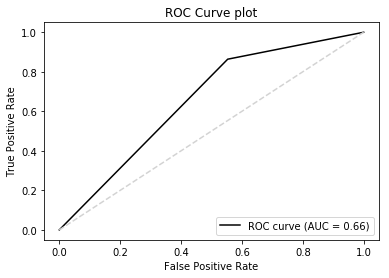

In [38]:
# ROC & AUC
from sklearn.metrics import roc_curve, roc_auc_score

ROC_CURVE = roc_curve(act, est)
FPR = ROC_CURVE[0]
TPR = ROC_CURVE[1]
AUC = roc_auc_score(act, est)

plt.plot(FPR, TPR, '-', label="ROC curve (AUC = %0.2f)" % AUC, color= 'black')
plt.plot([0, 1], [0, 1], 'k--', color = 'lightgrey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve plot')
plt.legend(loc="lower right")
plt.show()

In [39]:
# F1 SCORE
from sklearn.metrics import f1_score

f1_score = f1_score(y_true=act, y_pred=est, average='macro')
print("%0.2f" %f1_score)

0.66


In [40]:
# compute the AVERAGE PRECISION SCORE
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(act, est)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.68


Text(0.5,1,'2-class Precision-Recall curve: AP=0.68')

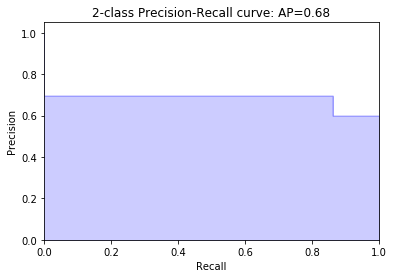

In [41]:
# plot precision-recall curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(act, est)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [28]:
# Human mistake solution
# Not deep learning base

In [29]:

"""
Sample script -------------------------------
fuzz.ratio("this is a test", "this is a test!") # 철자, 순서 모두 일치
fuzz.partial_ratio("this is a test", "!!!!this is a test!!!!") # 앞뒤에 철자 오류가 있어도 중간에 맞으면
fuzz.token_sort_ratio("fuzzy wuzzy was a bear", "! wuzzy fuzzy was a bear")# patial + 정렬 후 철자 모두 일치
fuzz.token_sort_ratio("fuzzy was a bear", "fuzzy fuzzy was a bear")
fuzz.token_set_ratio("fuzzy was a bear", "fuzzy fuzzy was a bear")
choices = ["Atlanta Falcons", "New York Jets", "New York Giants", "Dallas Cowboys"]
process.extract("new york jets", choices, limit=2)
process.extractOne("cowboys", choices)
"""

# with open("./Datasets/state_province.pkl",'wb') as f:
#     pickle.dump(state_province_dictionary, f)
    
with open("./Datasets/state_province.pkl",'rb') as f:
    state_province_dictionary = pickle.load(f)

# state_province_dictionary.keys()
correct_state_province_nm = state_province_dictionary['state_province_wikidict']

target_words= []
similar_words = []

for j in range(len(state_province_dictionary['state_province_nm'])):
    target_word = state_province_dictionary['state_province_nm'][j]
    similar_word = process.extract(target_word,correct_state_province_nm, limit=1)
    target_words.append(target_word)
    similar_words.append(similar_word)

result = pd.DataFrame({
    "state_province_nm":target_words,
    "est_state_province_nm":[similar_words[i][0][0] for i in range(len(similar_words))]})

result.tail()

state_province_nm est_state_province_nm
244          YUCAT��N               Yucatán
245           YURIRIA   Baja California Sur
246               ZAC             Zacatecas
247              ZAC.             Zacatecas
248         ZACATECAS             Zacatecas